# Algorytmy Macierzowe
## Zadanie 3: Mnożenie macierzy rzadkich
## Autorzy: Jan Izydorczyk, Aleksander Wójtowicz

# Cel zadania
Celem zadania było wykonanie eksperymentu polegającego na przetestowaniu czasu mnożenia macierzy rzadkich, w zależności od ich reprezentacji. 

W zadanym problemie testowaliśmy kombinacje:
- Reprezentacja gęsta $\times$ Reprezentacja gęsta
- Reprezentacja gęsta $\times$ Reprezentacja Coordinate System 

# Wybór macierzy

Jako macierz testową wybraliśmy blokową macierz powstałą z macierzy typu rIGA, wygenerowanej za pomocą dołączonego skryptu w zestawie zadania (używając funkcji `massmatrix`, z parametrami `2, 4, 2, 2`). Macierz bazowa ma rozmiar $49 \times 49$, macierz wynikowa powstała z zwielokrotnienia tej macierzy wzdłuż każdej osi $2^5$ razy, co ostatnie daje macierz o wymiarach $49 \cdot 2^5 \times 49 \cdot 2^5 = 1568 \times 1568$.

Jest to największa macierz, jaka była testowana w pierwszym zadaniu.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import iface

In [7]:
def load_base_matrix():  
    with open('riga49.csv', 'r') as file:
        return iface.read_matrix(file)
    
    
def generate_matrix(q):
    t = load_base_matrix()
    return np.block([[t] * q] * q)

In [4]:
q = 2**5
A = generate_matrix(q)
B = A
AxB = A@B
T = load_base_matrix()

# Wizualizacja macierzy

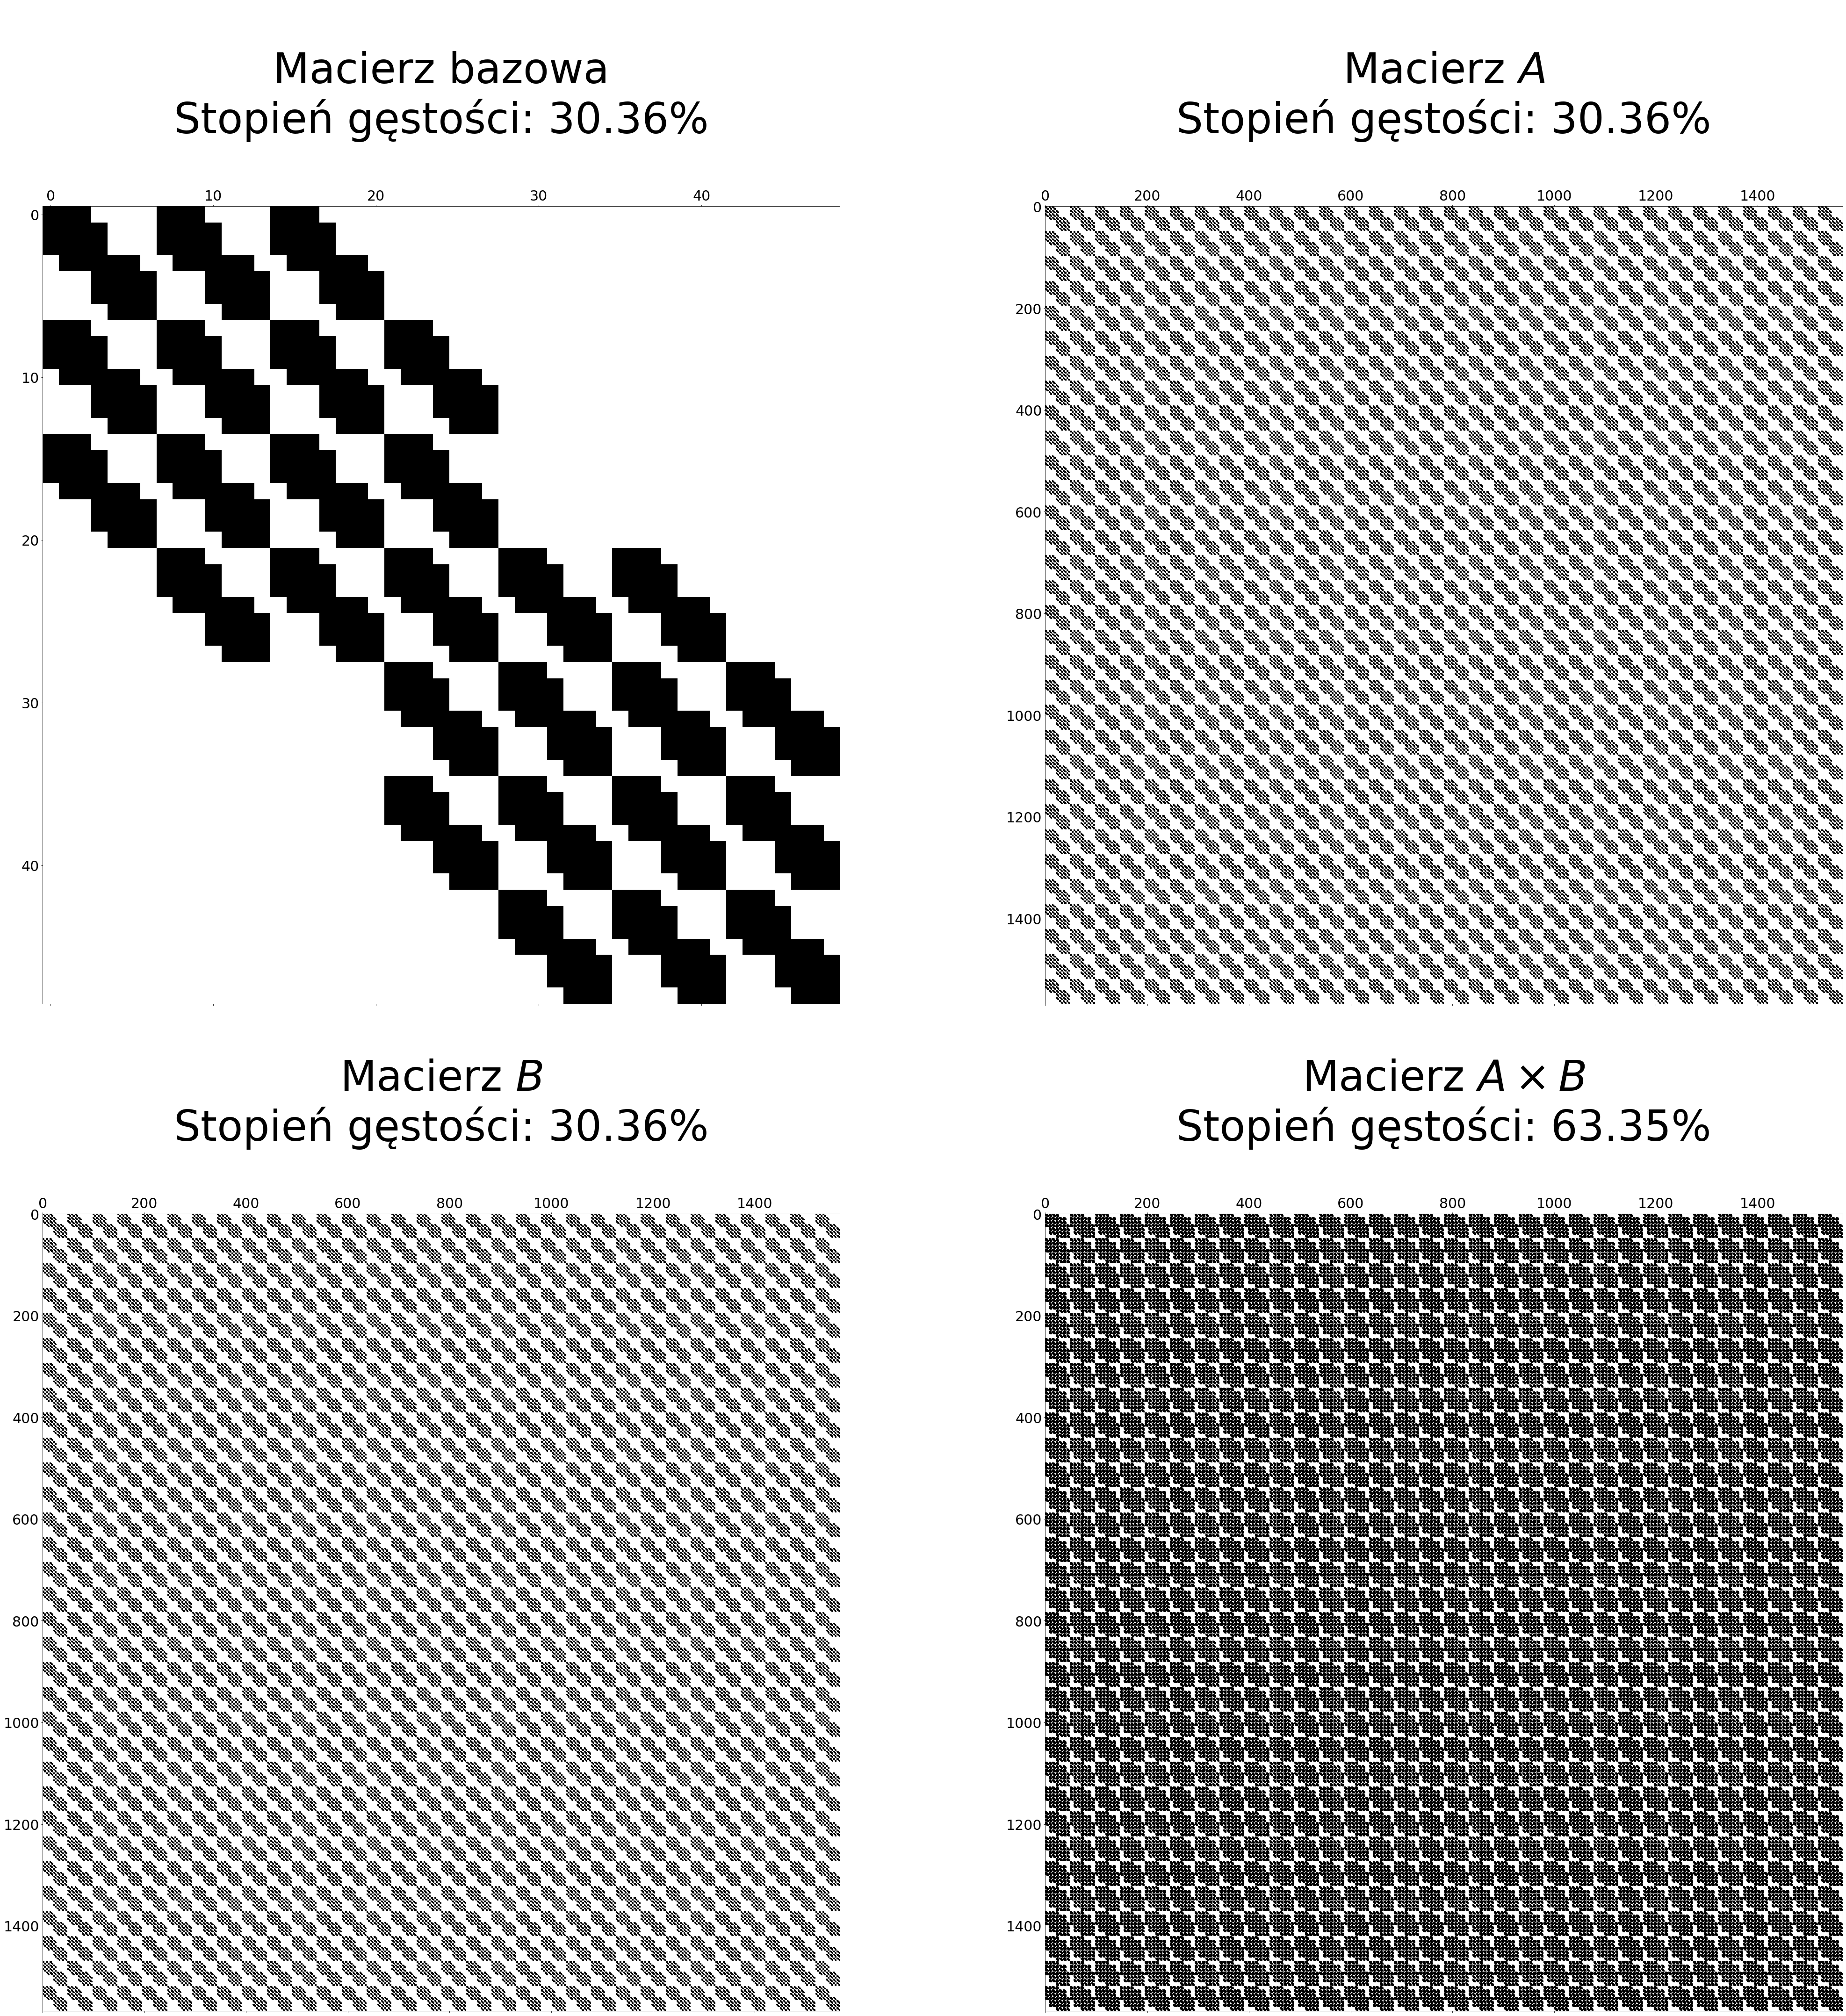

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (60, 60))
axs = axs.flatten()

matrices = [T, A, B, AxB]
titles = ['Macierz bazowa', 'Macierz $A$', 'Macierz $B$', 'Macierz $A \\times B$']


for ax, matrix, title in zip(axs, matrices, titles):
    density = np.count_nonzero(matrix) / matrix.shape[0] / matrix.shape[1]
    ax.spy(matrix)
    ax.set_title(f'\n{title}\nStopień gęstości: {100*density:.2f}%\n', fontsize=90)
    ax.tick_params(axis='both', labelsize=30)

fig.tight_layout()
plt.show()

# Omówienie programu mnożącego macierze i reprezentacji macierzy

Program mnożący macierze został zaimplementowany w języku C. Wykorzystaliśmy kompilator `gcc` z flagami: `-O3 -Wall -march=native -fno-loop-interchange`.

Naszym zadaniem było przemnożenie macierzy w postaci Coordinate Format przez macierz gęstą. Coordinate Format, to reprezentacja macierzy w której dla każdej niezerowej komórki przechowujemy jej wiersz, kolumnę oraz wartość. Taką reprezentację można przechowywać w trzech tablicach tej samej długości, albo jako lista krotek (struktur). W naszym programie tak wyglądają typy reprezentujące dane:

```c
typedef struct {
    size_t m;
    size_t n;
    float values[];
} dense_matrix_t;

typedef struct {
    size_t row;
    size_t col;
    float value;
} row_maj_coord_cell_t;

typedef struct {
    size_t m;
    size_t n;
    size_t len;
    row_maj_coord_cell_t values[];
} row_maj_coord_matrix_t;
```

Możemy zauważyć, że taka reprezentacja będzie korzystna dla macierzy rzadkich.

W przypadku macierzy gęstej (typ `dense_matrix_t`) wykorzystanie pamięci zawsze wynosi `sizeof(dense_matrix_t)` + $m$ * $n$ * `sizeof(typ_komórki)`, tj. $16 + 4mn$ lub $16 + 8mn$ bajtów.

W przypadku macierzy Coordinate Format (typ `row_maj_coord_matrix_t`) wykorzystanie pamięci jest zależne od gęstości macierzy. Wyniesie ono `sizeof(row_maj_coord_matrix_t)` + `len` * `sizeof(row_maj_coord_cell_t)`, tj. $24 + len * 24$ bajtów.

Drobna dygresja: ze względu na to, że działamy na komputerze 64 bitowym i w strukturze znajdują się pola 8-bajtowe (z 8-bajtowym wyrównaniem), to zarówno dla typów `float` i `double` struktura przechowująca komórki formatu Coordinate Format będzie miała rozmiar 24 bajty.

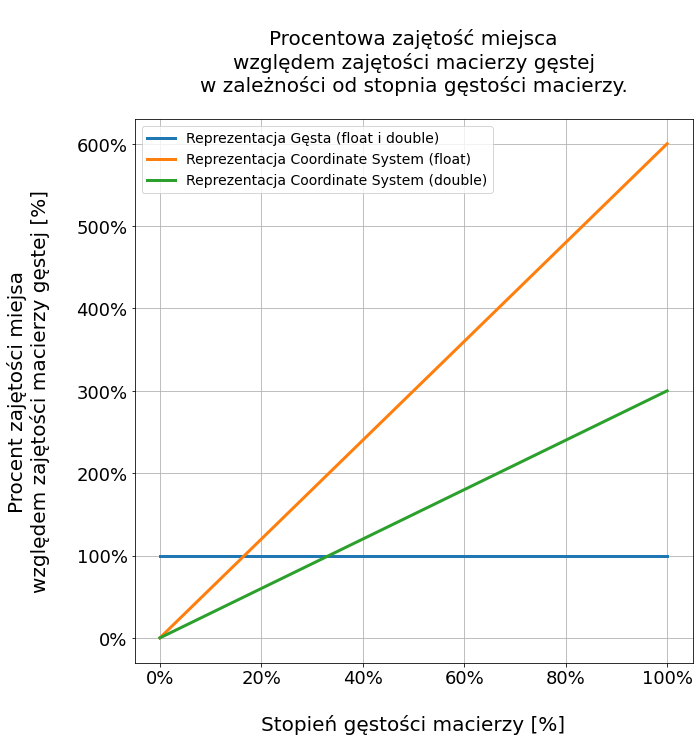

In [6]:
from matplotlib.ticker import PercentFormatter as pf

density = np.linspace(0, 1, 1000)
ys_dense = np.ones_like(density)
ys_sparse_float = np.linspace(0, 24/4, density.shape[0])
ys_sparse_double = np.linspace(0, 24/8, density.shape[0])

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(density, ys_dense, label='Reprezentacja Gęsta (float i double)', zorder=3, linewidth=3)
ax.plot(density, ys_sparse_float, label='Reprezentacja Coordinate System (float)', zorder=3, linewidth=3)
ax.plot(density, ys_sparse_double, label='Reprezentacja Coordinate System (double)', zorder=3, linewidth=3)

ax.yaxis.set_major_formatter(pf(1.0))
ax.xaxis.set_major_formatter(pf(1.0))
title = 'Procentowa zajętość miejsca\nwzględem zajętości macierzy gęstej\nw zależności od stopnia gęstości macierzy.'
ax.set_title(f'\n{title}\n', fontsize=20)
ax.set_xlabel('\nStopień gęstości macierzy [%]', fontsize=20)
ax.set_ylabel('Procent zajętości miejsa\nwzględem zajętości macierzy gęstej [%]\n', fontsize=20)
ax.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=18)
ax.grid(zorder=-3)

Zdecydowaliśmy się przechowywać komórki Coordinate Format w kolejności row-major, tj. kolejne komórki mają rosnący nr kolumny, a następnie nr wiersza. Dzięki temu porządek iteracji jest podobny jak w mnożeniu dwóch macierzy gęstych, i najrozsądniejszą kolejnością mnożenia zgodnie z analizą przeprowadzoną na zajęciach jest porządek `ipj`.

```c
int coord_dense_matmul(dense_matrix_t *a, dense_matrix_t *b, dense_matrix_t **out_result) {
    size_t m = a->m;
    size_t n = b->n;

    dense_matrix_t *result = make_dense_matrix(m, n);
    row_maj_coord_matrix_t *a_sparse = dense_to_row_maj_coord(a);

    result->m = m;
    result->n = n;

    for (size_t i_cell = 0; i_cell < a_sparse->len; i_cell++) {
        for (size_t j = 0; j < n; j++) {
            row_maj_coord_cell_t *cell = &a_sparse->values[i_cell];
            size_t i = cell->row;
            size_t p = cell->col;
            CELL(result, i, j) += cell->value * CELL(b, p, j);
        }
    }

    free(a_sparse);

    *out_result = result;
    return 0;
}
```

Kod konwertujący macierz gęstą na macierz Coordinate Format jest równie trywialny.

```c
row_maj_coord_matrix_t *dense_to_row_maj_coord(dense_matrix_t *input) {
    size_t nonzeros = 0;
    for (size_t i = 0; i < input->m * input->n; i++) {
        if (input->values[i] != .0) {
            nonzeros++;
        }
    }

    row_maj_coord_matrix_t *result = calloc(sizeof(*result) + nonzeros * sizeof(*result->values), 1);
    result->m = input->m;
    result->n = input->n;
    result->len = nonzeros;

    size_t next = 0;
    for (size_t i = 0; i < input->m; i++) {
        for (size_t j = 0; j < input->n; j++) {
            if (CELL(input, i, j) != .0) {
                result->values[next++] = (row_maj_coord_cell_t){
                    .row = i,
                    .col = j,
                    .value = CELL(input, i, j)};
            }
        }
    }

    return result;
};
```

Napisaliśmy również interfejs do naszego programu dla języka Python i biblioteki NumPy. Jego listing został umieszczony na końcu sprawozdania.

In [5]:
calc = iface.calc

# Testy mnożenia różnych kombinacji reprezentacji macierzy



Dla każdej wersji wykonujemy 20 testów, które są następnie uśredniane.

Dodatkowo, oprócz mierzenia tylko całkowitego czasu wykonania mnożenia, mierzyliśmy osobno czas zmiany formatu macierzy jak i czas wykonywania głównych obliczeń.

In [6]:
representations = [
    'dense',
    'coord'
] 

def measure_time(A, B, representations=representations, tries=1):
    res_df = []
    for representation in representations:
        sum_time_prep = 0
        sum_time_calc = 0
        for _ in range(tries):
            time_prep, time_calc, _ = calc(A, B, representation)
            sum_time_prep += time_prep
            sum_time_calc += time_calc
        avg_time_prep = sum_time_prep / tries
        avg_time_calc = sum_time_calc / tries
        res_df.append([representation, avg_time_prep, avg_time_calc])
        print(f'{representation}: preparation - {avg_time_prep:.2f}s, calculation - {avg_time_calc: .2f}s')
    res = pd.DataFrame(res_df, columns=('representation', 'avg_time_prep', 'avg_time_calc'))
    res['avg_time_whole'] = res['avg_time_prep'] + res['avg_time_calc'] 
    return res

In [7]:
import os
force_recalculations = False
results_filename = 'results.csv' 
if not os.path.exists(results_filename) or force_recalculations:
    res_df = res_df = measure_time(A, B, tries=20)
    res_df.to_csv(results_filename)
else:
    res_df = pd.read_csv(results_filename, index_col = 0)

In [21]:
res_map = {'representation': 'Reprezentacja', 'avg_time_prep': 'Średni czas zmiany formatu [s]', 'avg_time_calc': 'Średni czas mnożenia [s]', 'avg_time_whole': 'Średni łączny czas [s]'}
rep_map = {'dense': 'Reprezentacja Gęsta', 'coord': 'Reprezentacja Coordindate Format'}
res_df.replace({'representation': rep_map}).rename(columns=res_map)

,Reprezentacja,Średni czas zmiany formatu [s],Średni czas mnożenia [s],Średni łączny czas [s]
0,Reprezentacja Gęsta,0.0000,1.03125,1.03125
1,Reprezentacja Coordindate Format,0.0067,0.26535,0.27205


In [9]:
matrix_size = '$49 \\cdot 2^{5} \\times 49 \\cdot 2^{5}$'

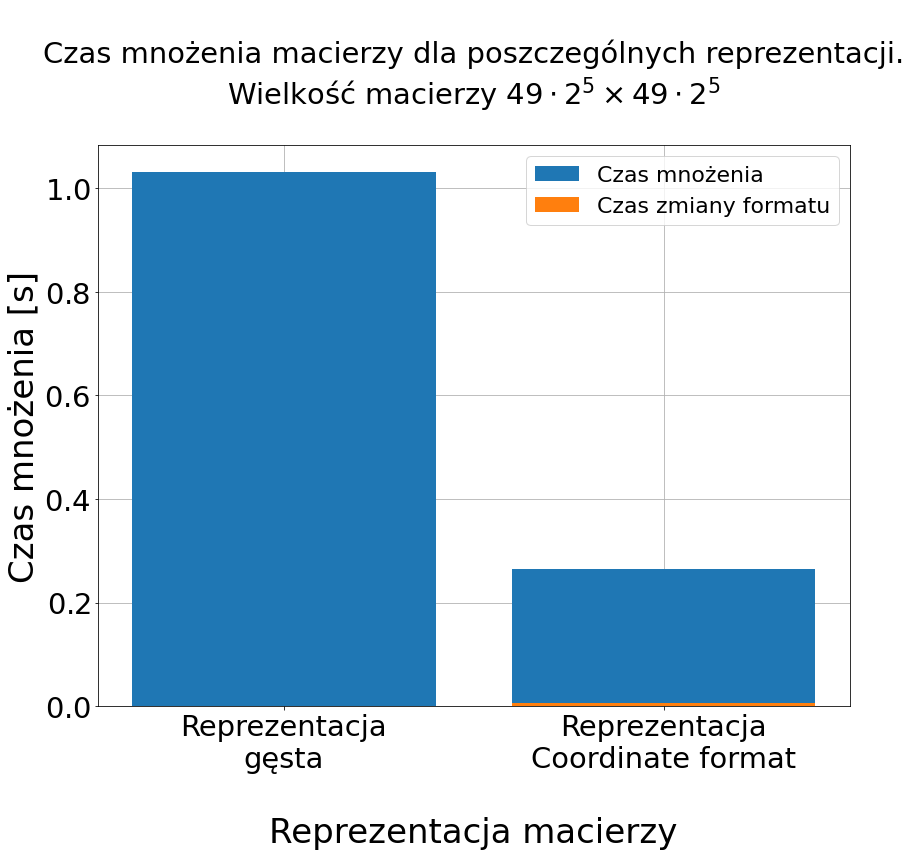

In [16]:
rep_map = {
    'dense': 'Reprezentacja\ngęsta',
    'coord': 'Reprezentacja\nCoordinate format'
}
fig = plt.figure(figsize = (12, 12))
plt.title(f'\nCzas mnożenia macierzy dla poszczególnych reprezentacji.\nWielkość macierzy {matrix_size}\n', fontsize = 29)
plt.xlabel('\nReprezentacja macierzy', fontsize = 34)
plt.ylabel('Czas mnożenia [s]', fontsize = 34)
plt.tick_params(axis='both', which='major', labelsize = 29)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
# plt.yscale('log')
plt.grid(zorder=-1)

xs, ys_calc, ys_prep = res_df['representation'].map(rep_map), res_df['avg_time_calc'], res_df['avg_time_prep']
p_calc = plt.bar(xs, ys_calc, zorder=3)
p_prep =  plt.bar(xs, ys_prep, zorder=3)

plt.legend((p_calc[0], p_prep[0]), ('Czas mnożenia', 'Czas zmiany formatu'), fontsize=22)

fig.tight_layout()
plt.show()

# Wnioski

Dla wybranej macierzy rzadkiej reprezentacja w formacie Coordinate Format pozwoliła uzyskać czterokrotne przyspieszenie obliczeń, uwzględniając łaczny czas wykonywnia obliczeń podczas mnożenia, jak i czas konwersji macierzy z formatu gęstego na Coordinate Format, mimo dość wysokich gęstości przetwarzanych przez nas macierzy.